# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

## Load *Dataset*
Load data from the given pickle file

In [2]:
# mount Google Drive to access the dataset
import pickle
# load the data set
pklData = pickle.load(open('./train_data.pkl', 'rb'))
def normalize(X:np.ndarray):
    # print(X.shape)
    mean = np.average(X,axis=1).reshape(X.shape[0],1)
    # print(mean.shape)
    X = X-mean
    std=np.std(X,axis=1).reshape(X.shape[0],1)
    # print(std.shape)
    X = X/std
    # print(X[0])
    return X
def standardize(X:np.ndarray):
    minvals = np.min(X,axis=1).reshape(X.shape[0],1)
    maxvals = np.max(X,axis=1).reshape(X.shape[0],1)
    X = (X-minvals)/(0.0001+maxvals-minvals)
    return X
X = np.array(pklData['X'])
y = np.array(pklData['y'])
X = normalize(X)

# TODO:update training set, testing set size so total = 60k
k = 100
X_train = X[:10000]
Y_train = y[:10000]

# print(Y_train.shape)
print(np.unique(Y_train,return_counts=True)[1])
X_test = X[k:2*k]
Y_test = y[k:2*k]
hidLaySize = 256
numDigs = 10
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library


[ 968 1104 1022  989 1011  919  994 1046  992  955]


c:\Users\HARDIK RAJPAL\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


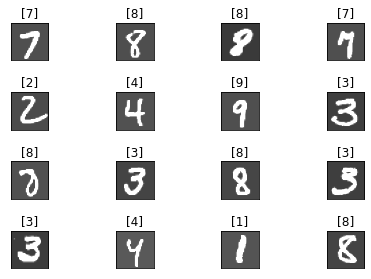

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
selection = np.random.choice(np.arange(X_train.shape[0]),size=16)
selImages = X_train[selection]
selLabels = Y_train[selection]
fig,axs = plt.subplots(4,4)
fig.tight_layout()
from typing import List
# axs:List[plt.Axes]
# axs[0].imshow()
for i in range(4):
    for j in range(4):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].imshow(selImages[4*i+j].reshape(28,28),cmap='gray',vmin=-1,vmax=1)
        axs[i,j].set_title(selLabels[4*i+j])
plt.show()

## Building up parts of our classifier

**Activation functions**

In [4]:
def relu(z:np.ndarray):
    negz = z < 0;ans = z.copy()
    ans[negz] = 0
    return ans
def sigmoid(z:np.ndarray):
    return 1/(1 + np.exp(-z))
def sigmoid_derivative(z:np.ndarray):
    return sigmoid(z)*(1-sigmoid(z))
def softmax(z:np.ndarray):
    b = np.exp(z)
    b = b/np.sum(b)
    # np.apply_along_axis(lambda y: print(np.sum(y)),1,b)
    return b

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [5]:
def init_params(sizeList):
    return [np.random.normal(0,1,size=size) for size in sizeList]
def init_bias(sizeList):
    # return [np.random.normal(0,1,size=size) for size in sizeList]
    return [np.zeros(size) for size in sizeList]

**Forward Propagation**

In [6]:

def forward_propg(X:np.ndarray, weights:List[np.ndarray],biases:List[np.ndarray]):
    "X is a list of images of size 784"
    "X.shape = (N,784)"
    "weights[0].shape = (hls,784)"
    "biases[0].shape = (hls)"
    "z1.shape = (N,hls)"
    "weights[1].shape = (10, hls)"
    "biases[1].shape = (10)"
    hls = weights[0].shape[0]
    actFunc = relu
    actFunc2 = sigmoid
    z1 = np.matmul(X,weights[0].transpose())
    z1 = z1 + biases[0]
    "z1.shape = (N,hls)"
    #doubt: batch normalization?
    a1 = actFunc(z1)
    a1 = standardize(a1)
    #N,hls = (N,784)x(hls,784)
    z2 = np.matmul(a1, weights[1].transpose())
    z2 = z2+ biases[1]
    a2 = actFunc(z2)
    a2 = standardize(a2)
    probs = standardize(np.apply_along_axis(
        lambda y:(y+1)/np.sum(y+1),
        1,
        a2
    ))
    "a2.shape = (N,10)"
    # print(1.000001-a2)
    logits = np.vectorize(lambda x:np.log(abs(x/(1.001-x))))(a2)
    """
    X: input data
    returns: logits, output of each layer z1,z2,
    activation of each layer: a1,a2
    """
    return logits,z1,z2,a1,a2,probs


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [7]:
def backward_propg(weights, biases,X, yscores, outputs,lr):
    "X.shape = (N,784)"
    "yscores.shape = (N,10): true labels"
    "outputs = [z1,a1,z2,a2]:"
    "z2.shape = (N,10)"
    "z1.shape = (N,hls)"
    "biases[0] = (hls)"
    "biases[1] = (10)"
    "weights[0] = (hls,784)"
    "weights[1] = (10,hls)"
    N = X.shape[0];z1,a1,z2,a2 = outputs;hls = weights[0].shape[0]
    # a2diffy = (a2-yscores)*sigmoid_derivative(z2)
    a2diffy = (a2-yscores)

    #               10xN,Nxh
    dwo = (2/N)*np.matmul(a2diffy.transpose(),a1)
    weights[1]-=lr*dwo
    biases[1]-=np.average(a2diffy,axis=0)
    dEseps = (2/10)*np.matmul(a2diffy,weights[1])
    #Nx10  10xh
    #Nxh
                    # hx784 = hxN x Nx784
    dwh = np.matmul(dEseps.transpose(),X)/X.shape[0]
    weights[0]-=lr*(dwh)
    biases[0]-=lr*(np.average(dEseps,axis=0))
    return weights,biases

In [8]:
def cost_func(scores:np.ndarray,y:np.ndarray,params):
    "scores: (N,10)"
    "y: (N,10)"
    N = scores.shape[0]
    # print(scores.shape,y.shape)
    #correct the loss function
    diff = (scores-y)**2
    losses = np.apply_along_axis(
        lambda x:np.sum(diff[x],axis=1),
        0,
        np.arange(N)
    )
    "losses.shape = (N,1)"
    # print(f"losses shape:{losses.shape}")
    dataLoss = np.average(losses)
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    return dataLoss,losses
def accuracy(predictions, y:np.ndarray):
    y=y.flatten()
    # print(predictions.shape,y.shape)
    # print(np.where(predictions==y)[0])
    # print(np.where(predictions==y)[0].shape,y.shape[0])
    return np.round(100*np.where(predictions==y)[0].shape[0]/y.shape[0],2)


## Integrate everything

In [9]:
from IPython.display import clear_output
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """

    weights = init_params([(hidden_nodes,784),(numDigs,hidden_nodes)])
    biases = init_bias([hidden_nodes,numDigs])
    valToScores = lambda val:np.vectorize(lambda x: 1 if x==val else 0)
    aranged = np.arange(10)#[1,2,...,10]
    scoreArray  =np.apply_along_axis(
        lambda y_elem:valToScores(y_elem)(aranged),
        1,
        y
    )
    # print(scoreArray[:10])
    numbatches = 100
    mbs = int(X.shape[0]/numbatches)
    pltable=np.zeros((2,epochs))
    # print(f'mbs:{mbs}')
    #mini batch size
    for i in range(epochs):
        accs = []
        for j in range(numbatches):
            logits,z1,z2,a1,a2,probs = forward_propg(X[mbs*j:mbs*(j+1)],weights,biases)
            cost,losses = cost_func(probs,scoreArray[mbs*j:mbs*(j+1)],[])
            preds = np.apply_along_axis(
                lambda x:np.argsort(x)[-1],
                1,
                probs)
            # print(probs[:10])
            acc = accuracy(preds,y[mbs*j:mbs*(j+1)].reshape(mbs))
            accs.append(acc)
            newweights, newbiases = backward_propg(weights,biases,X[mbs*j:mbs*(j+1)],scoreArray[mbs*j:mbs*(j+1)],[z1,a1,z2,a2],lr)
            weights = newweights
            biases = newbiases
        pltable[0,i] = cost;pltable[1,i]=np.average(accs)
        # if(i%5==0):
        #     clear_output(wait=True)
        #     # plt.plot(np.arange(epochs)[:i+1],pltable[0,:i+1],pltable[1,:i+1])
        #     plt.plot(np.arange(epochs)[:i+1],pltable[0,:i+1])
        #     plt.show()
        print(f'itr:{i}, cost:{pltable[0,i]},accur:{pltable[1,i]}')
            # print(i,)
            # print cost at every 100 or so iterations
        # backward propagation
    print(f'hls: {hidden_nodes}; maxacc:{np.max(pltable[1,:])}')
    return weights,biases,np.max(pltable[1,:])
# maxaccs = []
# for hlstmp in range(10,hidLaySize,5):
    # maxaccs.append(train(X_train,Y_train,hidden_nodes=hlstmp,epochs=100)[1])
w,b,max = train(X_train,Y_train,hidden_nodes=hidLaySize,epochs=50,lr=1e-1)

# print(maxaccs)
# print(np.unique(Y_train,return_counts=True)[1])

C:\Users\HARDIK RAJPAL\AppData\Local\Temp\ipykernel_3916\3607970557.py:44: RuntimeWarning: divide by zero encountered in log
  logits = np.vectorize(lambda x:np.log(abs(x/(1.001-x))))(a2)
c:\Users\HARDIK RAJPAL\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: divide by zero encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


itr:0, cost:0.4793028941960385,accur:60.94
itr:1, cost:0.3772659516298846,accur:76.65
itr:2, cost:0.35626433292466797,accur:79.41
itr:3, cost:0.333312697802578,accur:80.83
itr:4, cost:0.316187563445906,accur:81.69
itr:5, cost:0.3128906317281564,accur:82.47
itr:6, cost:0.2967373898067703,accur:83.1
itr:7, cost:0.28990477040001844,accur:83.36
itr:8, cost:0.27934931340859653,accur:83.79
itr:9, cost:0.27441369684158234,accur:84.07
itr:10, cost:0.260652811219795,accur:84.43
itr:11, cost:0.2468432947737871,accur:84.85
itr:12, cost:0.26288187986296313,accur:85.04
itr:13, cost:0.27353989502765735,accur:85.19
itr:14, cost:0.2381244334327599,accur:85.44
itr:15, cost:0.23531765075844815,accur:85.81
itr:16, cost:0.24382556746436634,accur:85.94
itr:17, cost:0.2218556304200963,accur:86.14
itr:18, cost:0.2180420350017092,accur:86.44
itr:19, cost:0.22691661131034102,accur:86.59
itr:20, cost:0.23250978612119103,accur:86.66
itr:21, cost:0.23613750413422113,accur:86.86
itr:22, cost:0.24473700968361098,ac

In [22]:
# print((list(map(lambda z:(z[0]*5+10,z[1]),list(enumerate(maxaccs))))))

[(10, 15.0), (15, 15.0), (20, 13.0), (25, 12.0), (30, 12.0), (35, 7.0), (40, 13.0), (45, 19.0), (50, 12.0), (55, 13.0), (60, 10.0), (65, 6.0), (70, 17.0), (75, 12.0), (80, 15.0), (85, 12.0), (90, 13.0), (95, 11.0), (100, 18.0), (105, 12.0), (110, 10.0), (115, 4.0), (120, 10.0), (125, 14.0), (130, 16.0), (135, 11.0), (140, 10.0), (145, 13.0), (150, 13.0), (155, 9.0), (160, 12.0), (165, 8.0), (170, 11.0), (175, 13.0), (180, 8.0), (185, 13.0), (190, 22.0), (195, 15.0), (200, 13.0), (205, 14.0), (210, 14.0), (215, 11.0), (220, 17.0), (225, 15.0), (230, 9.0), (235, 10.0), (240, 11.0), (245, 9.0), (250, 11.0), (255, 22.0)]


In [60]:
tn = 1000
def predict(X, updated_weights,biases):
    _,_,_,_,_,probs=forward_propg(X,updated_weights,biases)
    # print(probs.shape)
    # np.savetxt('preds.csv',probs)
    # np.savetxt('ans.csv',Y_test[:tn])
    # for i in range(tn):
    #     plt.scatter(np.arange(1,11),probs[i,:])
    #     plt.xticks(np.arange(1,11))
    #     plt.show()
        # print(probs[i,:])
        # print(np.argsort(probs[i,:]))
    # print()
    
    return np.apply_along_axis(lambda x: np.argsort(x)[-1],1,probs)
preds = predict(X_test[:tn],w,b)
# print(preds.shape)
print(accuracy(preds,Y_test[:tn]))

94.0


C:\Users\HARDIK RAJPAL\AppData\Local\Temp\ipykernel_46304\3416355029.py:41: RuntimeWarning: divide by zero encountered in log
  logits = np.vectorize(lambda x:np.log(abs(x/(1.001-x))))(a2)


### Save as pickle

In [63]:
pklData2 = pickle.load(open('./model_200050048.pkl', 'rb'))
hd = pklData2['z']
w2 = [np.array(pklData2['layer_0_wt']).transpose(),np.array(pklData2['layer_1_wt']).transpose()]
b2 = [np.array(pklData2['layer_0_bias']).flatten(),np.array(pklData2['layer_1_bias']).flatten()]
preds = predict(X_test[:tn],w2,b2)
print(accuracy(preds,Y_test[:tn]))

94.0


C:\Users\HARDIK RAJPAL\AppData\Local\Temp\ipykernel_46304\3416355029.py:41: RuntimeWarning: divide by zero encountered in log
  logits = np.vectorize(lambda x:np.log(abs(x/(1.001-x))))(a2)


In [62]:
import pickle
import random
# from google.colab import files

roll_num = "200050048" # enter ldap
hidden_dim = hidLaySize # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': w[0].transpose(), # layer 0 weight (784, z)
    'layer_0_bias': b[0].reshape((hidden_dim,1)), # layer 0 bias (z, 1)
    'layer_1_wt': w[1].transpose(), # layer 1 weight (z, 10)
    'layer_1_bias': b[1].reshape((10,1)) # layer 1 bias (10, 1)
}
print(w[0].shape)
assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    # files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

(256, 784)
